In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import glob
import os
import pyarrow.parquet as pq
import unidecode
import numpy as np
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
import torch

C:\Users\lilou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the Oracle DataFrame from a CSV file
df_oracle = pd.read_csv("df_oracle.csv", sep=";")

# Extract the last part of the FS_manual_path after '>' and remove leading/trailing spaces
df_oracle['FS_tag'] = df_oracle['FS_manual_path'].str.split('>').str[-1].str.strip()

# Load the cleaned FourSquare categories DataFrame from CSV
df_fs = pd.read_csv('Database/Clean_categories/categories_FS_clean.csv', sep=';')

In [3]:
# Define a function to determine the match type between OSM and FS tags
def get_match_type(row):
    if row["OSM_tag"] == row["FS_tag"]:
        return "PM"  # Perfect Match of Lexical Match
    else:
        # Count the number of elements in FS_manual_path
        path_length = len(row["FS_manual_path"].split(">"))
        if path_length > 1:
            return "SM"  # Semantic Match
        else:
            return "MCM"  # Main Category Match

# Apply the function to each row to create a new 'match_type' column
df_oracle["match_type"] = df_oracle.apply(get_match_type, axis=1)

# Extract the first element of FS_manual_path as FS_main
df_oracle["FS_main"] = df_oracle["FS_manual_path"].str.split(">").str[0].str.strip()

# Extract the first element of OSM_path as OSM_main
df_oracle["OSM_main"] = df_oracle["OSM_path"].str.split(">").str[0].str.strip()

In [ ]:
#LaTeX code of the table with only the matches by main category.
df_test = df_oracle[["OSM_tag", "OSM_main", "FS_tag", "match_type"]]
df_test = df_test[df_test["match_type"] == "MCM"]
df_test = df_test[["OSM_tag", "OSM_main", "FS_tag"]]


latex_code = df_test.to_latex(index=False)  # index=False pour ne pas afficher l'index

print(latex_code)

\begin{tabular}{lll}
\toprule
OSM_tag & OSM_main & FS_tag \\
\midrule
boat sharing & amenity & travel transportation \\
hairdresser supply & shop & retail \\
social centre & amenity & arts entertainment \\
subway & route & travel transportation \\
brewing supplies & shop & retail \\
kiosk & building & retail \\
car sharing & amenity & travel transportation \\
tram & route & travel transportation \\
shower & amenity & community government \\
country store & shop & retail \\
swingerclub & amenity & arts entertainment \\
brothel & amenity & arts entertainment \\
switch & railway & travel transportation \\
tracks & route & travel transportation \\
military surplus & shop & retail \\
boat & shop & retail \\
gatehouse & building & community government \\
trade & shop & retail \\
funicular & railway & travel transportation \\
grandstand & building & sports recreation \\
passing place & highway & travel transportation \\
cape & natural & landmarks outdoors \\
kneipp water cure & amenity & land

## Number of lexical, semantic, and main category matches

### By OSM main categories

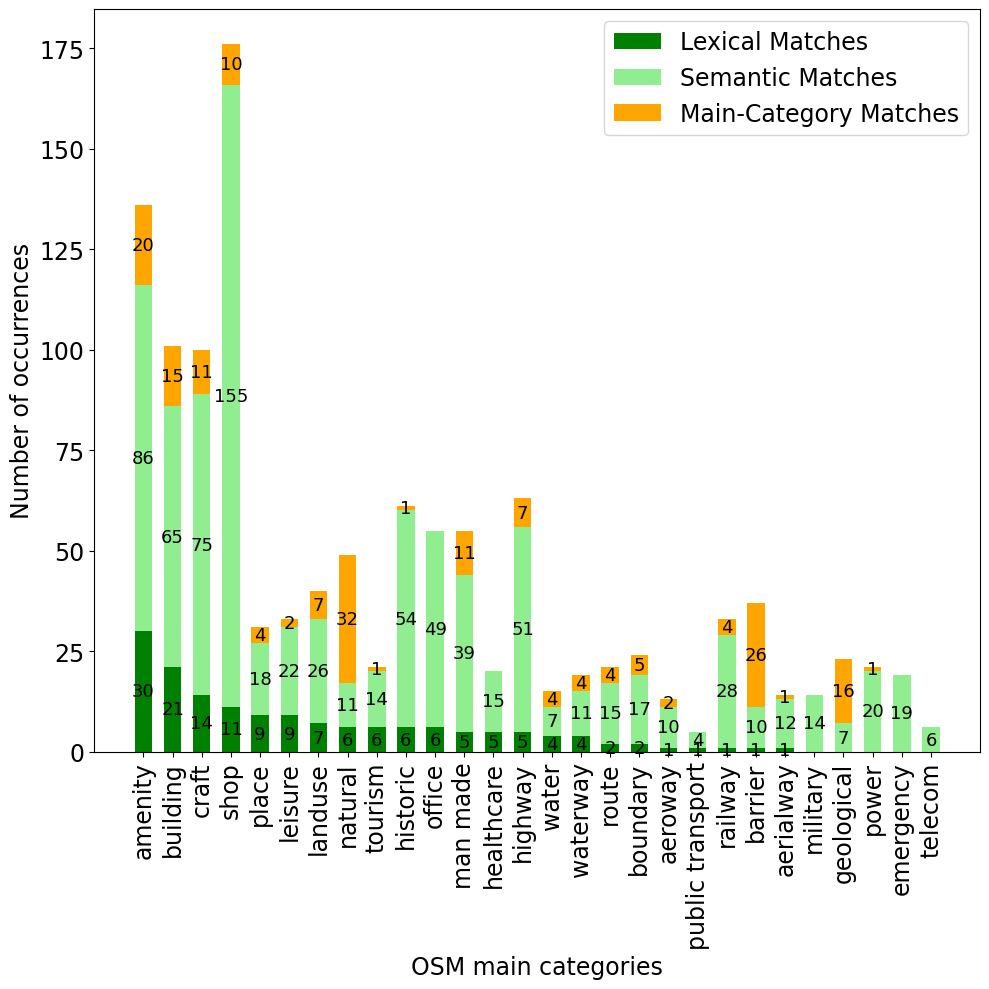

In [4]:
import matplotlib.pyplot as plt

# Create a sorted crosstab of OSM_main vs match_type
counts = pd.crosstab(df_oracle["OSM_main"], df_oracle["match_type"])
counts = counts.sort_values(by="PM", ascending=False)

# Get categories and corresponding values for each match type
categories = counts.index.tolist()
pm = counts["PM"] if "PM" in counts else [0]*len(counts)
sm = counts["SM"] if "SM" in counts else [0]*len(counts)
mcm = counts["MCM"] if "MCM" in counts else [0]*len(counts)
x = range(len(categories))

# Plot stacked bars with reduced width
bar_width = 0.6
plt.figure(figsize=(10, 10))
bars_pm = plt.bar(x, pm, width=bar_width, color="green", label="Lexical Matches")
bars_sm = plt.bar(x, sm, width=bar_width, bottom=pm, color="lightgreen", label="Semantic Matches")
bars_mcm = plt.bar(x, mcm, width=bar_width, bottom=pm+sm, color="orange", label="Main-Category Matches")

# Add labels at the center of each segment
for bar, val in zip(bars_pm, pm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, val/2, str(val),
                 ha="center", va="center", color="black", fontsize=13)

for bar, base, val in zip(bars_sm, pm, sm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + val/2, str(val),
                 ha="center", va="center", color="black", fontsize=13)

for bar, base, val in zip(bars_mcm, pm+sm, mcm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + val/2, str(val),
                 ha="center", va="center", color="black", fontsize=13)

# Set axes, labels, legend, and style
plt.xticks(x, categories, rotation=90, fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel("Number of occurrences", fontsize=17)
plt.xlabel("OSM main categories", fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()
plt.show()

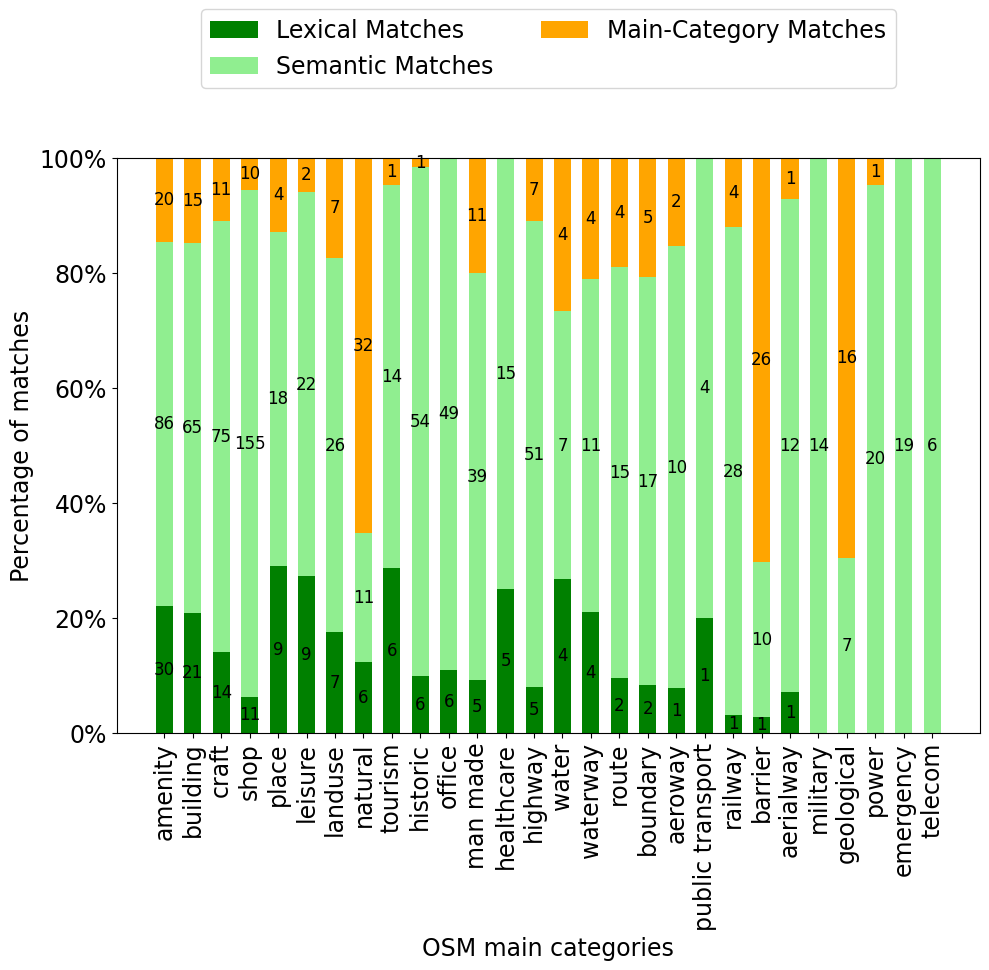

In [17]:
import matplotlib.pyplot as plt

# Create a sorted crosstab of OSM_main vs match_type
counts = pd.crosstab(df_oracle["OSM_main"], df_oracle["match_type"])
counts = counts.sort_values(by="PM", ascending=False)

# Get categories and corresponding values for each match type
categories = counts.index.tolist()
pm = counts["PM"] if "PM" in counts else [0]*len(counts)
sm = counts["SM"] if "SM" in counts else [0]*len(counts)
mcm = counts["MCM"] if "MCM" in counts else [0]*len(counts)

# Calculate totals per category to convert to percentages
totals = pm + sm + mcm
pm_pct = pm / totals * 100
sm_pct = sm / totals * 100
mcm_pct = mcm / totals * 100
x = range(len(categories))

# Plot stacked bars with reduced width
bar_width = 0.6
plt.figure(figsize=(10, 10))
bars_pm = plt.bar(x, pm_pct, width=bar_width, color="green", label="Lexical Matches")
bars_sm = plt.bar(x, sm_pct, width=bar_width, bottom=pm_pct, color="lightgreen", label="Semantic Matches")
bars_mcm = plt.bar(x, mcm_pct, width=bar_width, bottom=pm_pct+sm_pct, color="orange", label="Main-Category Matches")

# Add labels with exact counts (not percentages)
for bar, val in zip(bars_pm, pm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(val),
                 ha="center", va="center", color="black", fontsize=12)

for bar, base, val in zip(bars_sm, pm_pct, sm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + bar.get_height()/2, str(val),
                 ha="center", va="center", color="black", fontsize=12)

for bar, base, val in zip(bars_mcm, pm_pct+sm_pct, mcm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + bar.get_height()/2, str(val),
                 ha="center", va="center", color="black", fontsize=12)

# Set axes, labels, and style
plt.xticks(x, categories, rotation=90, fontsize=17)
plt.yticks(range(0, 101, 20), [f"{i}%" for i in range(0, 101, 20)], fontsize=17)
plt.ylabel("Percentage of matches", fontsize=17)
plt.xlabel("OSM main categories", fontsize=17)
plt.legend(
    loc='lower center',         # anchor point of the legend
    bbox_to_anchor=(0.5, 1.1), # x=0.5 horizontally centered, y>1 for above the plot
    ncol=2,                     # number of columns
    fontsize=17
)
plt.ylim(0, 100)
plt.tight_layout()

# Optional: save figure as PDF
# plt.savefig("Repartition_of_LM_SM_MCM_in_OSM.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


### By FS main categories

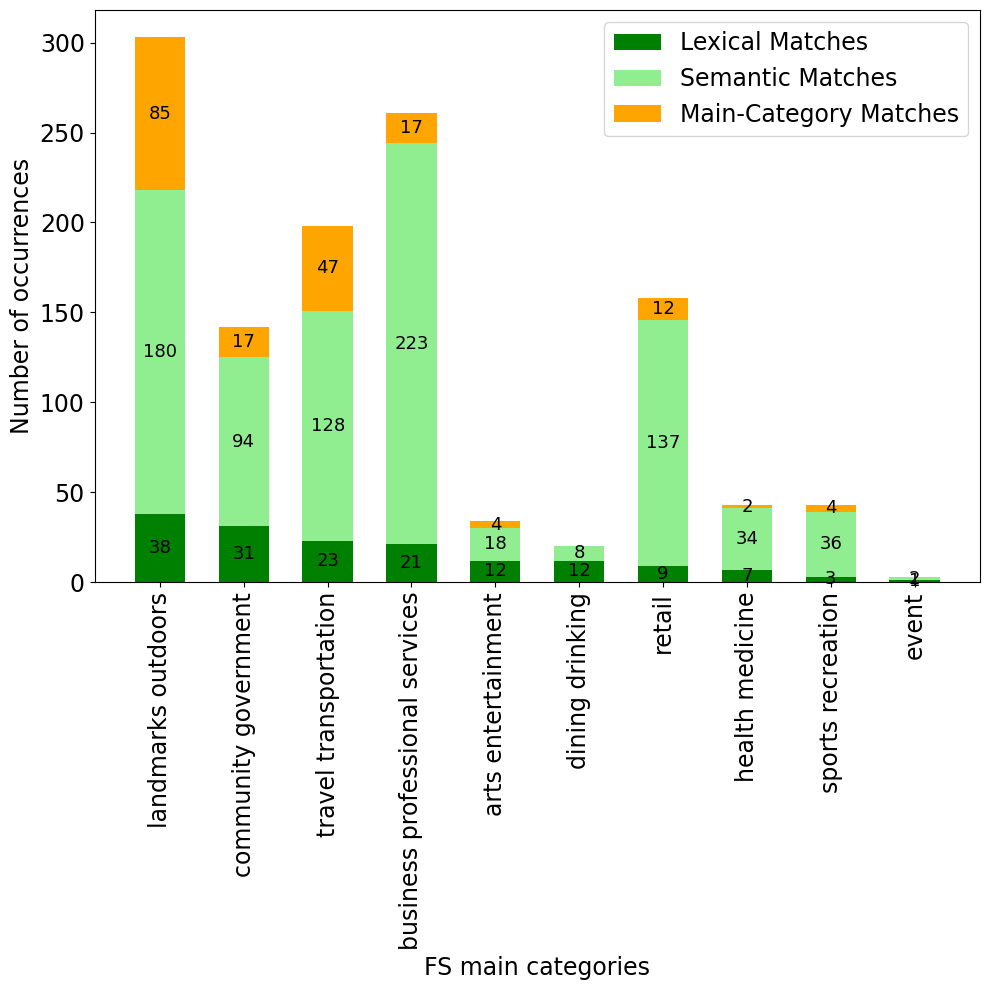

In [18]:
import matplotlib.pyplot as plt

# Create a sorted crosstab of FS_main vs match_type
counts = pd.crosstab(df_oracle["FS_main"], df_oracle["match_type"])
counts = counts.sort_values(by="PM", ascending=False)

# Get categories and corresponding values for each match type
categories = counts.index.tolist()
pm = counts["PM"] if "PM" in counts else [0]*len(counts)
sm = counts["SM"] if "SM" in counts else [0]*len(counts)
mcm = counts["MCM"] if "MCM" in counts else [0]*len(counts)
x = range(len(categories))

# Plot stacked bars with reduced width
bar_width = 0.6
plt.figure(figsize=(10, 10))
bars_pm = plt.bar(x, pm, width=bar_width, color="green", label="Lexical Matches")
bars_sm = plt.bar(x, sm, width=bar_width, bottom=pm, color="lightgreen", label="Semantic Matches")
bars_mcm = plt.bar(x, mcm, width=bar_width, bottom=pm+sm, color="orange", label="Main-Category Matches")

# Add labels at the center of each segment
for bar, val in zip(bars_pm, pm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, val/2, str(val),
                 ha="center", va="center", color="black", fontsize=13)

for bar, base, val in zip(bars_sm, pm, sm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + val/2, str(val),
                 ha="center", va="center", color="black", fontsize=13)

for bar, base, val in zip(bars_mcm, pm+sm, mcm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + val/2, str(val),
                 ha="center", va="center", color="black", fontsize=13)

# Set axes, labels, and style
plt.xticks(x, categories, rotation=90, fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel("Number of occurrences", fontsize=17)
plt.xlabel("FS main categories", fontsize=17)
plt.legend(fontsize=17)
plt.tight_layout()

# Display the plot
plt.show()

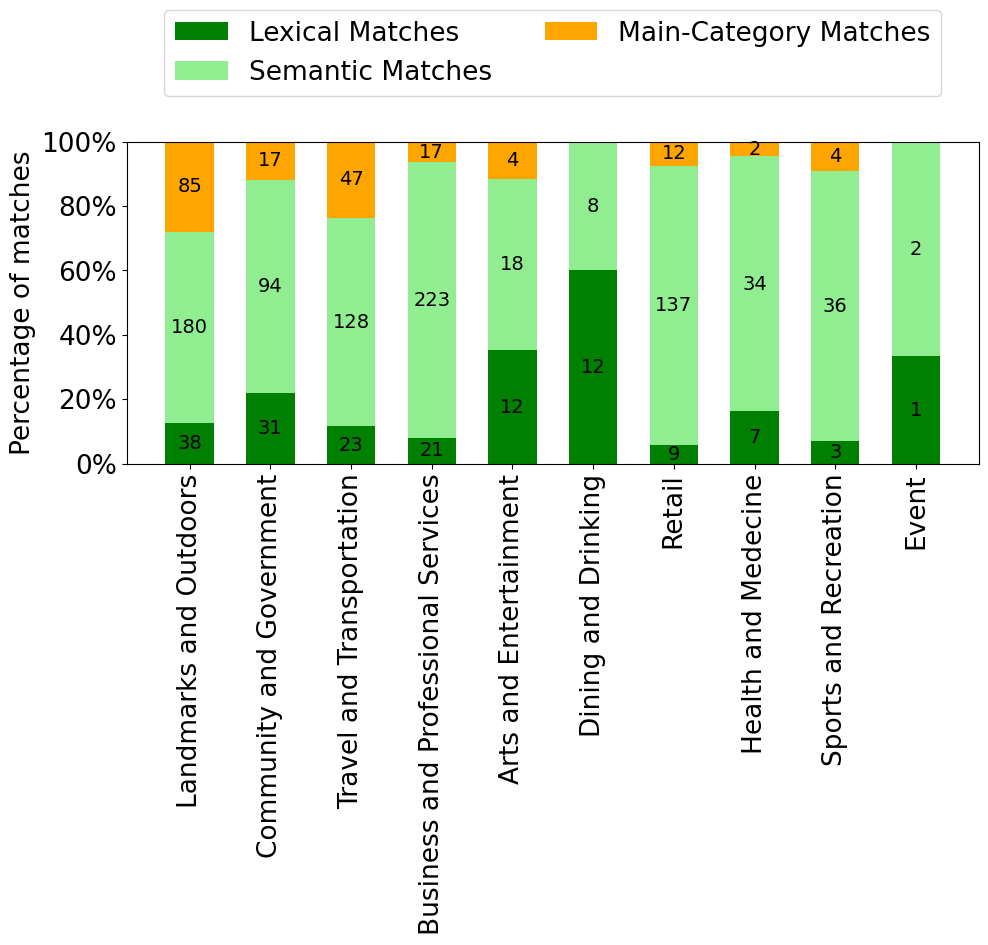

In [8]:
import matplotlib.pyplot as plt

mapping = {
    "landmarks outdoors": "Landmarks and Outdoors",
    "community government": "Community and Government",
    "travel transportation": "Travel and Transportation",
    "business professional services": "Business and Professional Services",
    "arts entertainment": "Arts and Entertainment",
    "dining drinking": "Dining and Drinking",
    "retail": "Retail",
    "health medicine": "Health and Medecine",
    "sports recreation": "Sports and Recreation",
    "event": "Event"

}

# Créer une nouvelle colonne en utilisant le dictionnaire
df_oracle["FS_main_unclean"] = df_oracle["FS_main"].map(mapping)


# Create a sorted crosstab of FS_main vs match_type
counts = pd.crosstab(df_oracle["FS_main_unclean"], df_oracle["match_type"])
counts = counts.sort_values(by="PM", ascending=False)

# Get categories and corresponding values for each match type
categories = counts.index.tolist()
pm = counts["PM"] if "PM" in counts else [0]*len(counts)
sm = counts["SM"] if "SM" in counts else [0]*len(counts)
mcm = counts["MCM"] if "MCM" in counts else [0]*len(counts)

# Calculate totals per category to convert to percentages
totals = pm + sm + mcm
pm_pct = pm / totals * 100
sm_pct = sm / totals * 100
mcm_pct = mcm / totals * 100
x = range(len(categories))

# Plot stacked bars with reduced width
bar_width = 0.6
plt.figure(figsize=(10, 10))
bars_pm = plt.bar(x, pm_pct, width=bar_width, color="green", label="Lexical Matches")
bars_sm = plt.bar(x, sm_pct, width=bar_width, bottom=pm_pct, color="lightgreen", label="Semantic Matches")
bars_mcm = plt.bar(x, mcm_pct, width=bar_width, bottom=pm_pct+sm_pct, color="orange", label="Main-Category Matches")

# Add labels with exact counts (not percentages)
for bar, val in zip(bars_pm, pm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(val),
                 ha="center", va="center", color="black", fontsize=14)

for bar, base, val in zip(bars_sm, pm_pct, sm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + bar.get_height()/2, str(val),
                 ha="center", va="center", color="black", fontsize=14)

for bar, base, val in zip(bars_mcm, pm_pct+sm_pct, mcm):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, base + bar.get_height()/2, str(val),
                 ha="center", va="center", color="black", fontsize=14)

# Set axes, labels, legend, and style
plt.xticks(x, categories, rotation=90, fontsize=19)
plt.yticks(range(0, 101, 20), [f"{i}%" for i in range(0, 101, 20)], fontsize=19)
plt.ylabel("Percentage of matches", fontsize=19)
plt.legend(
    loc='lower center',         # anchor point of the legend
    bbox_to_anchor=(0.5, 1.1), # x=0.5 horizontally centered, y>1 to place above the plot
    ncol=2,                     # number of columns
    fontsize=19
)
plt.ylim(0, 100)
plt.tight_layout()

# Optional: save figure as PDF
plt.savefig("Repartition_of_LM_SM_MCM_in_FS.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()

# CATEGORIES UTILISEES

In [20]:
# Define the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text: lowercase, remove accents, and filter stopwords
def clean_text(text):
    if text is None or pd.isna(text):  # Preserve None or NaN values
        return None
    
    text = str(text).lower()                        # Convert to lowercase
    text = unidecode.unidecode(text)                # Remove accents
    # text = re.sub(r'[^\w\s]', '', text)          # Remove punctuation (commented out)
    words = text.split()                            # Split text into words
    words = [word for word in words if word not in stop_words]  # Filter out stopwords
    return ' '.join(words)                          # Rejoin words into a cleaned string

# Apply the cleaning function to the 'Depth_1' column of df_fs
df_fs['Depth_1'] = df_fs['Depth_1'].apply(clean_text)

In [21]:
# Extract the first element of FS_manual_path as the main FS category
df_oracle['main_category_FS'] = df_oracle['FS_manual_path'].str.split('>').str[0].str.strip()

# Count the occurrences of each main FS category
df_oracle['main_category_FS'].value_counts()

# Store the counts in a variable
cat_fs_count = df_oracle['main_category_FS'].value_counts()

# Convert the counts into a DataFrame
df_cat_fs = cat_fs_count.reset_index()

# Rename the columns for clarity
df_cat_fs.columns = ['category', 'Unique_tag_osm']

In [ ]:
# Count the number of unique FS_manual_path values for each main FS category
category_counts = df_oracle.groupby('main_category_FS')['FS_manual_path'].nunique()

# Convert the counts into a DataFrame
df_counts = category_counts.reset_index()
df_counts.columns = ['category', 'Unique_tag_used']

# Add the counts column to df_cat_fs by merging on 'category'
df_cat_fs = df_cat_fs.merge(df_counts, on='category', how='outer')

In [ ]:
# Count the occurrences of each 'Depth_1' category in the FS dataset
category_counts = df_fs["Depth_1"].value_counts()

# Convert the counts into a DataFrame
df_counts = category_counts.reset_index()
df_counts.columns = ['category', 'Unique_tag_in_fs']

# Add the counts column to df_cat_fs by merging on 'category'
df_cat_fs = df_cat_fs.merge(df_counts, on='category', how='outer')

# Fill any missing values with 0
df_cat_fs = df_cat_fs.fillna(0)

In [25]:
df_cat_fs

,category,Unique_tag_osm,Unique_tag_used,Unique_tag_in_fs
0,landmarks outdoors,303.0,58.0,71
1,business professional services,261.0,112.0,195
2,travel transportation,198.0,49.0,72
3,retail,158.0,101.0,150
4,community government,142.0,53.0,127
5,health medicine,43.0,22.0,59
6,sports recreation,43.0,23.0,87
7,arts entertainment,34.0,26.0,72
8,dining drinking,20.0,17.0,392
9,event,3.0,3.0,17
